In [41]:
import carla
import logging
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [42]:
client = carla.Client('localhost',2000)
client.set_timeout(10.0)
print(client.get_available_maps())

['/Game/Carla/Maps/Town05', '/Game/Carla/Maps/Town02', '/Game/Carla/Maps/Town03', '/Game/Carla/Maps/Town04', '/Game/Carla/Maps/Town01']


In [43]:
world = client.load_world('Town02')
print(world)
#print(world.get_actors())
imagen = None

World(id=18246377355743227931)


In [44]:

class Images():
    
    def __init__(self):
        self.image = np.zeros(shape=(360, 540, 3), dtype=np.uint8)
        
    def get_image(self):
        return self.image

In [14]:
class Cameraman():
    
    def __init__(self, actor, width = 640, height = 480):
        self.width = width
        self.height = height
        self.imageOut = None
        self.actor = actor
        
        
    @staticmethod
    def parse_image_ext(self, image):
        self.imageOut = Cameraman.parse_image(image)
    
    @staticmethod
    def parse_image(self, image):
        array = np.frombuffer(image.raw_data, dtype=np.dtype("uint8"))
        array = np.reshape(array, (image.height, image.width, 4))
        array = array[:, :, :3]
        array = array[:, :, ::-1]
        return array.copy()

In [15]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  
    #image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) 
    image = image / 255 
    return image

In [45]:
def parse_image(image):
    image.convert(carla.ColorConverter.Raw)
    array = np.frombuffer(image.raw_data, dtype=np.dtype("uint8"))
    array = np.reshape(array, (image.height, image.width, 4))
    array = array[:, :, :3]
    array = array[:, :, ::-1]
    return array.copy()

def parse_image_ext(image, images):
    images.image = parse_image(image)

BoundingBox(Location(x=0.029219, y=-0.000000, z=0.735531), Extent(x=2.395890, y=1.081725, z=0.744160), Rotation(pitch=0.000000, yaw=0.000000, roll=0.000000))
Location(x=0.000000, y=0.000000, z=0.000000)
Actor(id=3695, type=vehicle.tesla.model3)
Vector3D(x=0.000000, y=0.000000, z=0.000000)
images


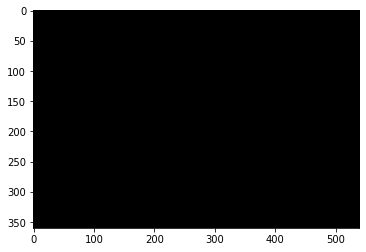

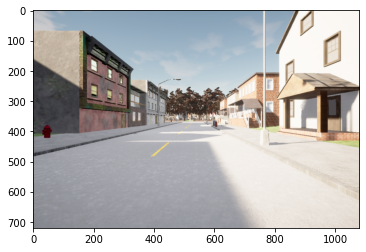

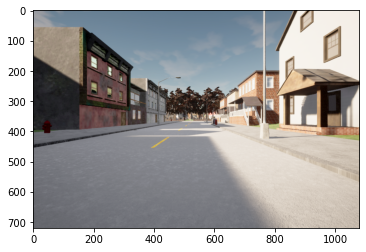

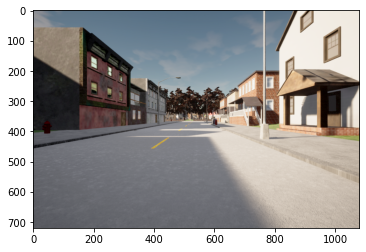

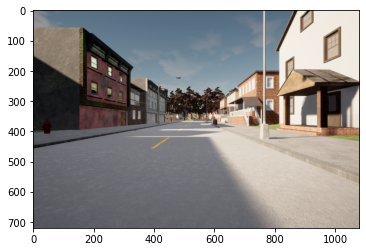

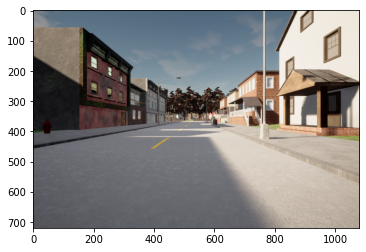

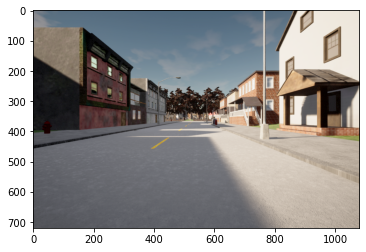

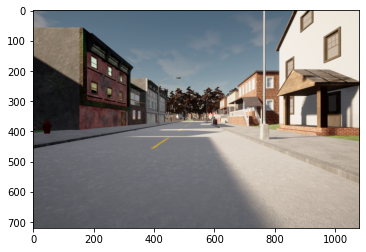

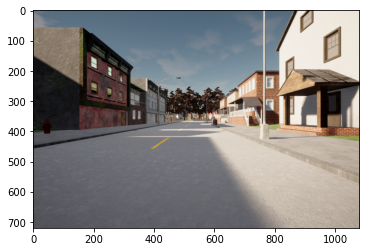

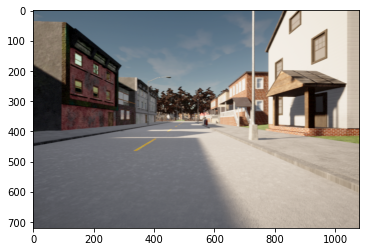

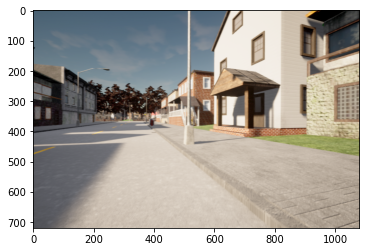

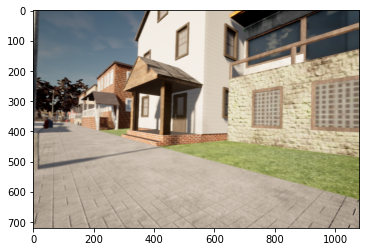

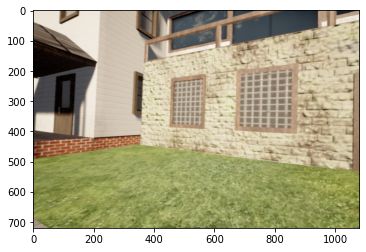

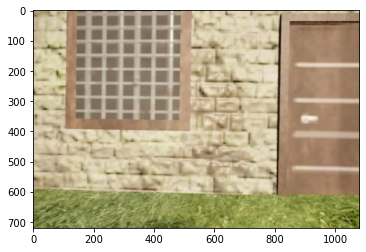

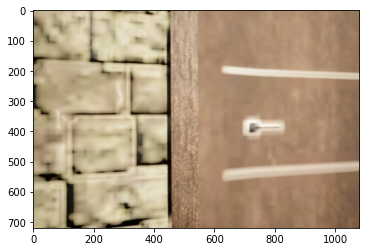

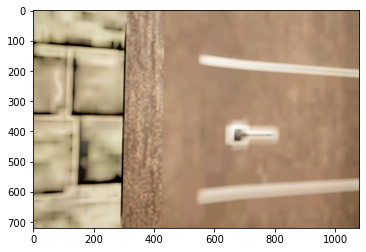

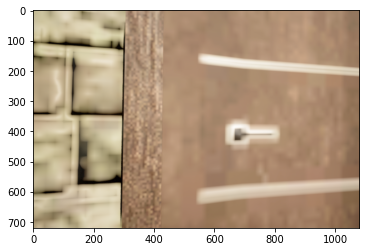

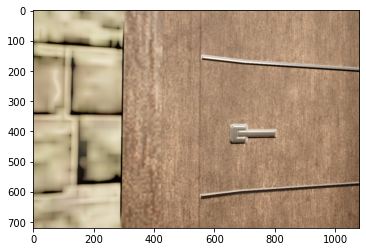


Done with tutorial_ego.


In [46]:
try:
    blueprint_library = world.get_blueprint_library()
    #print(blueprint_library)
    #blueprint_library = blueprint_library.filter('vehicle.*')
    #print(blueprint_library)
    tesla_blueprint = blueprint_library.find('vehicle.tesla.model3')
    tesla_blueprint.set_attribute('role_name','ego')
    spawn_points = world.get_map().get_spawn_points()

    if len(spawn_points) > 0:
        random.shuffle(spawn_points)
        transform = spawn_points[0]
        vehicle = world.spawn_actor(tesla_blueprint, transform)
    else:
        logging.warning('No points to spawn')

    print(vehicle.bounding_box)
    images = Images()
    print(vehicle.get_location())
    print(vehicle)
    print(vehicle.get_velocity())
    cam_bp = world.get_blueprint_library().find('sensor.camera.rgb')
    cam_bp.set_attribute("image_size_x", str(1080))
    cam_bp.set_attribute("image_size_y", str(720))
    
    cam_location = carla.Location(2,0,1)
    cam_rotation = carla.Rotation(0,0,0)
    cam_transform = carla.Transform(cam_location,cam_rotation)
    ego_cam = world.spawn_actor(cam_bp,cam_transform,attach_to=vehicle, attachment_type=carla.AttachmentType.Rigid)
    #ego_cam.listen(lambda image: image.save_to_disk('images/%.6d.jpg' % image.frame))
    ego_cam.listen(lambda image: parse_image_ext(image, images))

    #spectator = world.get_spectator()
    #world_snapshot = world.wait_for_tick() 
    #spectator.set_transform(vehicle.get_transform())

    #cameraman = Cameraman(vehicle)
    #print(cameraman.width)
    figure(1)
    print("images")
    while True:
        control = carla.VehicleControl(1.0,0)
        vehicle.apply_control(control)
        #image = Images(cameraman)
        #print(image.get_image)
        #print(images.image)
        
        plt.imshow(images.image)
        plt.show()
        #cv2.imshow('carla', images.image)
        #cv2.waitKey(1)
        #print(cameraman.imageOut)
        world_snapshot = world.wait_for_tick()

except KeyboardInterrupt:
    pass
    # --------------
    # Stop recording and destroy actors
    # --------------
    #client.stop_recorder()
finally:
    if vehicle is not None:
        if ego_cam is not None:
            ego_cam.stop()
            ego_cam.destroy()
        vehicle.destroy()
        cv2.destroyAllWindows() 
        print('\nDone with tutorial_ego.')